In [ ]:
CX%%bash
pip install -qU numpy==2.0.0          \
                scikit-learn==1.6.1   \
                xgboost==2.1.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 16.6 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
pylibcugraph-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, which is not installed.
stumpy 1.13.0 requires numba>=0.57.1, which is not installed.
cudf-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.
cudf-cu12 25.6.0 requires numba<0.62.0a0,>=0.59.1, which is not installed.
pynndescent 0.5.13 requires numba>=0.51.2, which is not installed.
nx-cugraph-cu12 25.6.0 requires cupy-cuda12x>=12.0.0, which is not installed.
cuml-cu12 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ================================================================
# Load cleaned DataFrame
# ================================================================
import pandas as pd

PICKLE_PATH = "/content/drive/MyDrive/MSc Research/final_df.pkl"
df = pd.read_pickle(PICKLE_PATH)

print(f"Loaded DataFrame with {len(df):,} rows.")

Loaded DataFrame with 188,988 rows.


In [ ]:
# =============================================================================
# Subsampling & Model Evaluation
# =============================================================================
import os, csv, json, joblib, time
import numpy as np
import pandas as pd


from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    ParameterGrid,
    KFold
)

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate


# --------------------------------
def stratified_subsample(data, frac=0.1, n_bins=10, random_state=42):
    if frac >= 1.0:
        return data.copy()
    tmp = data.copy()
    tmp["prem_bin"] = pd.qcut(tmp["PREMIUM"], q=n_bins, labels=False, duplicates="drop")
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    idx = next(splitter.split(tmp, tmp["prem_bin"]))[1]
    return tmp.iloc[idx].drop(columns=["prem_bin"])


## **XGBoost Hyperparameter Tuning (10% data)**





In [ ]:
# =============================================================================
# 3. Prepare 10% Subsample & Train/Test Split
# =============================================================================
BASE_DIR_10 = "/content/drive/MyDrive/MSc Research/HPT_10_grid"
os.makedirs(BASE_DIR_10, exist_ok=True)

df10 = stratified_subsample(df, frac=0.10)
X   = df10.drop(columns=["PREMIUM"])
y   = df10["PREMIUM"]

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"10% subsample → {len(df10):,} rows; train={len(Xtr):,}, test={len(Xte):,}")

# =============================================================================
# 3. Grid and CSV setup
# =============================================================================
param_grid_10 = {
    "n_estimators":     [500, 1000, 2000, 3000, 5000],
    "max_depth":        [3, 4, 6],
    "learning_rate":    [0.01, 0.05, 0.1],
    "subsample":        [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
}
all_params = list(ParameterGrid(param_grid_10))

RESULTS_FILE_10 = os.path.join(BASE_DIR_10, "xgb_grid_10_results.csv")
FIELDNAMES_10   = [
    "index", "params", "cv_rmse",
    "test_r2", "test_mae", "test_rmse", "test_mape",
    "tuning_time_s"
]
if not os.path.exists(RESULTS_FILE_10):
    with open(RESULTS_FILE_10, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_10).writeheader()


# =============================================================================
# 4. 5-fold CV splitter
# =============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# =============================================================================
# 5. Manual grid loop
# =============================================================================
best_cv_rmse = float("inf")
best_model   = None
best_idx     = None

for idx, params in enumerate(all_params):
    print(f"\nIteration {idx+1}/{len(all_params)} — params: {params}")
    start_time = time.time()

    # 5-fold CV to compute RMSE
    rmses = []
    for train_idx, val_idx in kf.split(Xtr):
        Xcv_tr, ycv_tr = Xtr.iloc[train_idx], ytr.iloc[train_idx]
        Xcv_val, ycv_val = Xtr.iloc[val_idx], ytr.iloc[val_idx]

        m = XGBRegressor(
            objective="reg:squarederror",
            tree_method="gpu_hist",
            eval_metric="rmse",
            early_stopping_rounds=50,
            random_state=42,
            verbosity=0,
            **params
        )
        m.fit(Xcv_tr, ycv_tr, eval_set=[(Xcv_val, ycv_val)], verbose=False)
        preds = m.predict(Xcv_val)
        rmses.append(np.sqrt(mean_squared_error(ycv_val, preds)))

    cv_rmse = float(np.mean(rmses))

    # retrain on full train & evaluate on test
    final_m = XGBRegressor(
        objective="reg:squarederror",
        tree_method="gpu_hist",
        eval_metric="rmse",
        early_stopping_rounds=50,
        random_state=42,
        verbosity=0,
        **params
    )
    final_m.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    ypred     = final_m.predict(Xte)
    test_r2   = r2_score(yte, ypred)
    test_mae  = mean_absolute_error(yte, ypred)
    test_rmse = np.sqrt(mean_squared_error(yte, ypred))
    test_mape = mean_absolute_percentage_error(yte, ypred)

    elapsed = time.time() - start_time
    print(f" → CV RMSE={cv_rmse:.4f} | Test RMSE={test_rmse:.2f} | Time={elapsed:.1f}s")

    # log to CSV
    with open(RESULTS_FILE_10, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_10).writerow({
            "index":         idx,
            "params":        json.dumps(params),
            "cv_rmse":       cv_rmse,
            "test_r2":       test_r2,
            "test_mae":      test_mae,
            "test_rmse":     test_rmse,
            "test_mape":     test_mape,
            "tuning_time_s": round(elapsed, 1)
        })

    # track best
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse
        best_model   = final_m
        best_idx     = idx

print(f"\nBest idx={best_idx}, CV RMSE={best_cv_rmse:.4f}")


# =============================================================================
# 6. Persist results & save best model
# =============================================================================
results10 = pd.read_csv(RESULTS_FILE_10)
joblib.dump(results10, os.path.join(BASE_DIR_10, "results10.pkl"))
results10.to_parquet(os.path.join(BASE_DIR_10, "results10.parquet"), index=False)

model_json = os.path.join(BASE_DIR_10, "xgb_best10.json")
model_pkl  = os.path.join(BASE_DIR_10, "xgb_best10.pkl")
best_model.save_model(model_json)
joblib.dump(best_model, model_pkl)

print(f"Saved best 10% model idx={best_idx} → {model_json}, {model_pkl}")


10% subsample → 18,899 rows; train=15,119, test=3,780

Iteration 1/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
 → CV RMSE=49.8452 | Test RMSE=48.72 | Time=4.7s

Iteration 2/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
 → CV RMSE=49.9187 | Test RMSE=48.83 | Time=4.9s

Iteration 3/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.6}
 → CV RMSE=47.7697 | Test RMSE=46.36 | Time=8.5s

Iteration 4/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.8}
 → CV RMSE=47.8171 | Test RMSE=46.39 | Time=8.9s

Iteration 5/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2000, 'subsample': 0.6}
 → CV RMSE=47.2472 | Test RMSE=45.60 | Time=16.3s

Iteration 6/180 — params: {'colsample_byt

### **SHAP**

In [ ]:
import shap, xgboost as xgb, pandas as pd

# ── Load best booster ───────────────────────────────────────────────
d = "/content/drive/MyDrive/MSc Research/HPT_10_grid"
bst = xgb.Booster()
bst.load_model(f"{d}/xgb_best10.json")   # uses the JSON you saved

# ── 10% data to explain ─────────────────────────────────────────────
full_df_10 = stratified_subsample(df, frac=0.10)
X_full_10  = full_df_10.drop(columns=["PREMIUM"])  # ← adjust name if needed

# ── Wrap Booster as XGBRegressor ────────────────────────────────────
model_10 = xgb.XGBRegressor()
model_10._Booster = bst
model_10._le      = None

# ── SHAP explainer & plots ──────────────────────────────────────────
explainer   = shap.TreeExplainer(model_10)
shap_values = explainer.shap_values(X_full_10)

In [ ]:
import os, json, numpy as np

out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "10", 0.10

# save raw SHAP + feature names + expected value
np.savez_compressed(f"{out_dir}/xgb_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_10.columns),
    expected_value=np.atleast_1d(explainer.expected_value).astype(np.float32)
)

# per-feature summary
df_feat = pd.DataFrame({
    "feature": X_full_10.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), 0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/xgb_mean_shap_{lab}.csv", index=False)

# meta
json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_10)},
          open(f"{out_dir}/xgb_shap_meta_{lab}.json", "w"))

print("Saved 10% SHAP data.")


Saved 10% SHAP data.


## **XGBoost Hyperparameter Tuning (25% data)**





In [ ]:
# =============================================================================
# 2. Load data & prepare 25% split
# =============================================================================
PICKLE_PATH = "/content/drive/MyDrive/MSc Research/final_df.pkl"
df = pd.read_pickle(PICKLE_PATH)

BASE_DIR_25 = "/content/drive/MyDrive/MSc Research/HPT_25_grid"
os.makedirs(BASE_DIR_25, exist_ok=True)

df25 = stratified_subsample(df, frac=0.25)
X    = df25.drop(columns=["PREMIUM"])
y    = df25["PREMIUM"]

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"25% subsample → {len(df25):,} rows; train={len(Xtr):,}, test={len(Xte):,}")


# =============================================================================
# 3. Grid and CSV setup
# =============================================================================
param_grid_25 = {
    "n_estimators":     [1000, 2000, 5000, 10000, 15000],
    "max_depth":        [4, 6, 8],
    "learning_rate":    [0.01, 0.05, 0.10],
    "subsample":        [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
}
all_params = list(ParameterGrid(param_grid_25))

RESULTS_FILE_25 = os.path.join(BASE_DIR_25, "xgb_grid_25_results.csv")
FIELDNAMES_25   = [
    "index", "params", "cv_rmse",
    "test_r2", "test_mae", "test_rmse", "test_mape",
    "tuning_time_s"
]
if not os.path.exists(RESULTS_FILE_25):
    with open(RESULTS_FILE_25, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_25).writeheader()


# =============================================================================
# 4. 5-fold CV splitter
# =============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# =============================================================================
# 5. Manual grid loop
# =============================================================================
best_cv_rmse = float("inf")
best_model   = None
best_idx     = None

for idx, params in enumerate(all_params):
    print(f"\nIteration {idx+1}/{len(all_params)} — params: {params}")
    start_time = time.time()

    # 5-fold CV to compute RMSE
    rmses = []
    for train_idx, val_idx in kf.split(Xtr):
        Xcv_tr, ycv_tr = Xtr.iloc[train_idx], ytr.iloc[train_idx]
        Xcv_val, ycv_val = Xtr.iloc[val_idx], ytr.iloc[val_idx]

        m = XGBRegressor(
            objective="reg:squarederror",
            tree_method="gpu_hist",
            eval_metric="rmse",
            early_stopping_rounds=50,
            random_state=42,
            verbosity=0,
            **params
        )
        m.fit(Xcv_tr, ycv_tr, eval_set=[(Xcv_val, ycv_val)], verbose=False)
        preds = m.predict(Xcv_val)
        rmses.append(np.sqrt(mean_squared_error(ycv_val, preds)))

    cv_rmse = float(np.mean(rmses))

    # retrain on full train & evaluate on test
    final_m = XGBRegressor(
        objective="reg:squarederror",
        tree_method="gpu_hist",
        eval_metric="rmse",
        early_stopping_rounds=50,
        random_state=42,
        verbosity=0,
        **params
    )
    final_m.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    ypred     = final_m.predict(Xte)
    test_r2   = r2_score(yte, ypred)
    test_mae  = mean_absolute_error(yte, ypred)
    test_rmse = np.sqrt(mean_squared_error(yte, ypred))
    test_mape = mean_absolute_percentage_error(yte, ypred)

    elapsed = time.time() - start_time
    print(f" → CV RMSE={cv_rmse:.4f} | Test RMSE={test_rmse:.2f} | Time={elapsed:.1f}s")

    # log to CSV
    with open(RESULTS_FILE_25, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_25).writerow({
            "index":         idx,
            "params":        json.dumps(params),
            "cv_rmse":       cv_rmse,
            "test_r2":       test_r2,
            "test_mae":      test_mae,
            "test_rmse":     test_rmse,
            "test_mape":     test_mape,
            "tuning_time_s": round(elapsed, 1)
        })

    # track best
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse
        best_model   = final_m
        best_idx     = idx

print(f"\nBest idx={best_idx}, CV RMSE={best_cv_rmse:.4f}")


# =============================================================================
# 6. Persist results & save best model
# =============================================================================
results25 = pd.read_csv(RESULTS_FILE_25)
joblib.dump(results25, os.path.join(BASE_DIR_25, "results25.pkl"))
results25.to_parquet(os.path.join(BASE_DIR_25, "results25.parquet"), index=False)

model_json = os.path.join(BASE_DIR_25, "xgb_best25.json")
model_pkl  = os.path.join(BASE_DIR_25, "xgb_best25.pkl")
best_model.save_model(model_json)
joblib.dump(best_model, model_pkl)

print(f"Saved best 25% model idx={best_idx} → {model_json}, {model_pkl}")

### **SHAP**

In [ ]:
import shap, xgboost as xgb, pandas as pd

# ── Load best booster ───────────────────────────────────────────────
d = "/content/drive/MyDrive/MSc Research/HPT_25_grid"
bst = xgb.Booster()
bst.load_model(f"{d}/xgb_best25.json")

# ── 25% data to explain ─────────────────────────────────────────────
full_df_25 = stratified_subsample(df, frac=0.25)
X_full_25  = full_df_25.drop(columns=["PREMIUM"])

# ── Wrap Booster as XGBRegressor ────────────────────────────────────
model_25 = xgb.XGBRegressor()
model_25._Booster = bst
model_25._le      = None

# ── SHAP explainer ──────────────────────────────────────────────────
explainer   = shap.TreeExplainer(model_25)
shap_values = explainer.shap_values(X_full_25)


In [ ]:
import os, json, numpy as np

out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "25", 0.25

# save raw SHAP + feature names + expected value
np.savez_compressed(f"{out_dir}/xgb_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_25.columns),
    expected_value=np.atleast_1d(explainer.expected_value).astype(np.float32)
)

# per-feature summary
df_feat = pd.DataFrame({
    "feature": X_full_25.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), 0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/xgb_mean_shap_{lab}.csv", index=False)

# meta
json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_25)},
          open(f"{out_dir}/xgb_shap_meta_{lab}.json", "w"))

print("Saved 25% SHAP data.")

Saved 25% SHAP data.


## **XGBoost Hyperparameter Tuning (50% data)**




In [ ]:
# =============================================================================
# 2. Load data & prepare 50% split
# =============================================================================
BASE_DIR_50 = "/content/drive/MyDrive/MSc Research/HPT_50_grid"
os.makedirs(BASE_DIR_50, exist_ok=True)

df50 = stratified_subsample(df, frac=0.50)
X    = df50.drop(columns=["PREMIUM"])
y    = df50["PREMIUM"]

Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print(f"50% subsample → {len(df50):,} rows; train={len(Xtr):,}, test={len(Xte):,}")


# =============================================================================
# 3. Grid and CSV setup
# =============================================================================
param_grid_50 = {
    "n_estimators":     [2000, 5000, 10000, 15000, 20000],
    "max_depth":        [6, 8, 10],
    "learning_rate":    [0.01, 0.05, 0.10],
    "subsample":        [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
}
all_params = list(ParameterGrid(param_grid_50))

RESULTS_FILE_50 = os.path.join(BASE_DIR_50, "xgb_grid_50_results.csv")
FIELDNAMES_50   = [
    "index", "params", "cv_rmse",
    "test_r2", "test_mae", "test_rmse", "test_mape",
    "tuning_time_s"
]
if not os.path.exists(RESULTS_FILE_50):
    with open(RESULTS_FILE_50, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_50).writeheader()


# =============================================================================
# 4. 5-fold CV splitter
# =============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# =============================================================================
# 5. Manual grid loop
# =============================================================================
best_cv_rmse = float("inf")
best_model   = None
best_idx     = None

for idx, params in enumerate(all_params):
    print(f"\nIteration {idx+1}/{len(all_params)} — params: {params}")
    start_time = time.time()

    # 5-fold CV
    rmses = []
    for train_idx, val_idx in kf.split(Xtr):
        Xcv_tr, ycv_tr = Xtr.iloc[train_idx], ytr.iloc[train_idx]
        Xcv_val, ycv_val = Xtr.iloc[val_idx], ytr.iloc[val_idx]

        m = XGBRegressor(
            objective="reg:squarederror",
            tree_method="gpu_hist",
            eval_metric="rmse",
            early_stopping_rounds=50,
            random_state=42,
            verbosity=0,
            **params
        )
        m.fit(Xcv_tr, ycv_tr, eval_set=[(Xcv_val, ycv_val)], verbose=False)
        preds = m.predict(Xcv_val)
        rmses.append(np.sqrt(mean_squared_error(ycv_val, preds)))

    cv_rmse = float(np.mean(rmses))

    # retrain on full train & evaluate on test
    final_m = XGBRegressor(
        objective="reg:squarederror",
        tree_method="gpu_hist",
        eval_metric="rmse",
        early_stopping_rounds=50,
        random_state=42,
        verbosity=0,
        **params
    )
    final_m.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    ypred     = final_m.predict(Xte)
    test_r2   = r2_score(yte, ypred)
    test_mae  = mean_absolute_error(yte, ypred)
    test_rmse = np.sqrt(mean_squared_error(yte, ypred))
    test_mape = mean_absolute_percentage_error(yte, ypred)

    elapsed = time.time() - start_time
    print(f" → CV RMSE = {cv_rmse:.4f} | Test RMSE = {test_rmse:.2f} | Time = {elapsed:.1f}s")

    # log to CSV
    with open(RESULTS_FILE_50, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_50).writerow({
            "index":         idx,
            "params":        json.dumps(params),
            "cv_rmse":       cv_rmse,
            "test_r2":       test_r2,
            "test_mae":      test_mae,
            "test_rmse":     test_rmse,
            "test_mape":     test_mape,
            "tuning_time_s": round(elapsed, 1)
        })

    # track best
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse
        best_model   = final_m
        best_idx     = idx

print(f"\nBest idx={best_idx}, CV RMSE={best_cv_rmse:.4f}")


# =============================================================================
# 6. Persist full results & save best model
# =============================================================================
results50 = pd.read_csv(RESULTS_FILE_50)
joblib.dump(results50, os.path.join(BASE_DIR_50, "results50.pkl"))
results50.to_parquet(os.path.join(BASE_DIR_50, "results50.parquet"), index=False)

# save best model
model_json = os.path.join(BASE_DIR_50, "xgb_best50.json")
model_pkl  = os.path.join(BASE_DIR_50, "xgb_best50.pkl")
best_model.save_model(model_json)
joblib.dump(best_model, model_pkl)

print(f"Saved best 50% model idx={best_idx} → {model_json}, {model_pkl}")

50% subsample → 94,494 rows; train=75,595, test=18,899

Iteration 1/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 2000, 'subsample': 0.6}
 → CV RMSE = 45.1322 | Test RMSE = 44.62 | Time = 31.2s

Iteration 2/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 2000, 'subsample': 0.8}
 → CV RMSE = 45.1156 | Test RMSE = 44.59 | Time = 31.4s

Iteration 3/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 5000, 'subsample': 0.6}
 → CV RMSE = 45.1279 | Test RMSE = 44.61 | Time = 33.1s

Iteration 4/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 5000, 'subsample': 0.8}
 → CV RMSE = 45.1050 | Test RMSE = 44.56 | Time = 34.6s

Iteration 5/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10000, 'subsample': 0.6}
 → CV RMSE = 45.1279 | Test RMSE = 44.61 | Time = 32.6s

Ite

### **SHAP**

In [ ]:
import shap, xgboost as xgb, pandas as pd

# Load best booster
d = "/content/drive/MyDrive/MSc Research/HPT_50_grid"
bst = xgb.Booster()
bst.load_model(f"{d}/xgb_best50.json")

# 50% data
full_df_50 = stratified_subsample(df, frac=0.50)
X_full_50  = full_df_50.drop(columns=["PREMIUM"])

# Wrap as regressor
model_50 = xgb.XGBRegressor()
model_50._Booster = bst
model_50._le      = None

# SHAP
explainer   = shap.TreeExplainer(model_50)
shap_values = explainer.shap_values(X_full_50)

In [ ]:
import os, json, numpy as np
out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "50", 0.50
np.savez_compressed(f"{out_dir}/xgb_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_50.columns),
    expected_value=np.atleast_1d(explainer.expected_value).astype(np.float32)
)

df_feat = pd.DataFrame({
    "feature": X_full_50.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), 0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/xgb_mean_shap_{lab}.csv", index=False)

json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_50)},
          open(f"{out_dir}/xgb_shap_meta_{lab}.json", "w"))

print("Saved 50% SHAP data.")

Saved 50% SHAP data.


## **XGBoost Hyperparameter Tuning  (75% data)**

In [ ]:
# =============================================================================
# 2. Prepare 75% Subsample & Train/Test Split
# =============================================================================
BASE_DIR_75 = "/content/drive/MyDrive/MSc Research/HPT_75"
os.makedirs(BASE_DIR_75, exist_ok=True)


# build and split
df75 = stratified_subsample(df, frac=0.75)
X    = df75.drop(columns=["PREMIUM"])
y    = df75["PREMIUM"]
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print(f"75% subsample → {len(df75):,} rows; train={len(Xtr):,}, test={len(Xte):,}")

# =============================================================================
# 3. Grid and CSV setup
# =============================================================================
param_grid_75 = {
    "n_estimators":     [5000, 10000, 15000, 20000, 25000],
    "max_depth":        [8, 10, 12],
    "learning_rate":    [0.005, 0.01, 0.05],
    "subsample":        [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
}
all_params = list(ParameterGrid(param_grid_75))

RESULTS_FILE_75 = os.path.join(BASE_DIR_75, "xgb_grid_75_results.csv")
FIELDNAMES_75   = [
    "index", "params", "cv_rmse",
    "test_r2", "test_mae", "test_rmse", "test_mape",
    "tuning_time_s"
]
if not os.path.exists(RESULTS_FILE_75):
    with open(RESULTS_FILE_75, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_75).writeheader()


# =============================================================================
# 4. 5-fold CV splitter
# =============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# =============================================================================
# 5. Manual grid loop
# =============================================================================
best_cv_rmse = float("inf")
best_model   = None
best_idx     = None

for idx, params in enumerate(all_params):
    print(f"\nIteration {idx+1}/{len(all_params)} — params: {params}")
    start_time = time.time()

    # 5-fold CV
    rmses = []
    for train_idx, val_idx in kf.split(Xtr):
        Xcv_tr, ycv_tr = Xtr.iloc[train_idx], ytr.iloc[train_idx]
        Xcv_val, ycv_val = Xtr.iloc[val_idx], ytr.iloc[val_idx]

        m = XGBRegressor(
            objective="reg:squarederror",
            tree_method="gpu_hist",
            eval_metric="rmse",
            early_stopping_rounds=50,
            random_state=42,
            verbosity=0,
            **params
        )
        m.fit(Xcv_tr, ycv_tr, eval_set=[(Xcv_val, ycv_val)], verbose=False)
        preds = m.predict(Xcv_val)
        rmses.append(np.sqrt(mean_squared_error(ycv_val, preds)))

    cv_rmse = float(np.mean(rmses))

    # retrain on full train & evaluate on test
    final_m = XGBRegressor(
        objective="reg:squarederror",
        tree_method="gpu_hist",
        eval_metric="rmse",
        early_stopping_rounds=50,
        random_state=42,
        verbosity=0,
        **params
    )
    final_m.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    ypred     = final_m.predict(Xte)
    test_r2   = r2_score(yte, ypred)
    test_mae  = mean_absolute_error(yte, ypred)
    test_rmse = np.sqrt(mean_squared_error(yte, ypred))
    test_mape = mean_absolute_percentage_error(yte, ypred)

    elapsed = time.time() - start_time
    print(f" → CV RMSE={cv_rmse:.4f} | Test RMSE={test_rmse:.2f} | Time={elapsed:.1f}s")

    # log to CSV
    with open(RESULTS_FILE_75, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_75).writerow({
            "index":         idx,
            "params":        json.dumps(params),
            "cv_rmse":       cv_rmse,
            "test_r2":       test_r2,
            "test_mae":      test_mae,
            "test_rmse":     test_rmse,
            "test_mape":     test_mape,
            "tuning_time_s": round(elapsed, 1)
        })

    # track best
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse
        best_model   = final_m
        best_idx     = idx

print(f"\nBest idx={best_idx}, CV RMSE={best_cv_rmse:.4f}")


# =============================================================================
# 6. Persist full results & best model
# =============================================================================
results75 = pd.read_csv(RESULTS_FILE_75)
joblib.dump(results75, os.path.join(BASE_DIR_75, "results75.pkl"))
results75.to_parquet(os.path.join(BASE_DIR_75, "results75.parquet"), index=False)

# save best model
model_json = os.path.join(BASE_DIR_75, "xgb_best75.json")
model_pkl  = os.path.join(BASE_DIR_75, "xgb_best75.pkl")
best_model.save_model(model_json)
joblib.dump(best_model, model_pkl)

print(f"Saved best 75% model idx={best_idx} → {model_json}, {model_pkl}")


75% subsample → 141,741 rows; train=113,392, test=28,349

Iteration 1/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 5000, 'subsample': 0.6}
 → CV RMSE=44.7240 | Test RMSE=44.74 | Time=79.8s

Iteration 2/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 5000, 'subsample': 0.8}
 → CV RMSE=44.7317 | Test RMSE=44.72 | Time=84.8s

Iteration 3/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 10000, 'subsample': 0.6}
 → CV RMSE=44.7240 | Test RMSE=44.74 | Time=79.6s

Iteration 4/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 10000, 'subsample': 0.8}
 → CV RMSE=44.7317 | Test RMSE=44.72 | Time=84.8s

Iteration 5/180 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 8, 'n_estimators': 15000, 'subsample': 0.6}
 → CV RMSE=44.7240 | Test RMSE=44.74 | Time=79.9s

Iteration 6/180 — params

### **SHAP**

In [ ]:
import shap, xgboost as xgb, pandas as pd

# Load best booster
d = "/content/drive/MyDrive/MSc Research/HPT_75"
bst = xgb.Booster()
bst.load_model(f"{d}/xgb_best75.json")

# 75% data
full_df_75 = stratified_subsample(df, frac=0.75)
X_full_75  = full_df_75.drop(columns=["PREMIUM"])

# Wrap as regressor
model_75 = xgb.XGBRegressor()
model_75._Booster = bst
model_75._le      = None

# SHAP
explainer   = shap.TreeExplainer(model_75)
shap_values = explainer.shap_values(X_full_75)

In [ ]:
import os, json, numpy as np
out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "75", 0.75
np.savez_compressed(f"{out_dir}/xgb_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_75.columns),
    expected_value=np.atleast_1d(explainer.expected_value).astype(np.float32)
)

df_feat = pd.DataFrame({
    "feature": X_full_75.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), 0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/xgb_mean_shap_{lab}.csv", index=False)

json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_75)},
          open(f"{out_dir}/xgb_shap_meta_{lab}.json", "w"))

print("Saved 75% SHAP data.")

## **XGBoost Hyperparameter Tuning (100% data)**

In [ ]:
# ================================================================
# 4. Split data
# ================================================================
from sklearn.model_selection import train_test_split

BASE_DIR_FULL = "/content/drive/MyDrive/MSc Research/HPT_full_grid"
os.makedirs(BASE_DIR_FULL, exist_ok=True)

X   = df.drop(columns=["PREMIUM"])
y   = df["PREMIUM"]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"100% data → {len(df):,} rows; train={len(Xtr):,}, test={len(Xte):,}")


# =============================================================================
# 3. Grid and CSV setup
# =============================================================================
param_grid_full = {
    "n_estimators":     [10_000, 20_000, 30_000, 40_000],
    "max_depth":        [10, 12, 15],
    "learning_rate":    [0.005, 0.01, 0.05],
    "subsample":        [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
}
all_params = list(ParameterGrid(param_grid_full))

RESULTS_FILE_FULL = os.path.join(BASE_DIR_FULL, "xgb_grid_full_results.csv")
FIELDNAMES_FULL   = [
    "index", "params", "cv_rmse",
    "test_r2", "test_mae", "test_rmse", "test_mape",
    "tuning_time_s"
]
if not os.path.exists(RESULTS_FILE_FULL):
    with open(RESULTS_FILE_FULL, "w", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_FULL).writeheader()


# =============================================================================
# 4. 5-fold CV splitter
# =============================================================================
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# =============================================================================
# 5. Manual grid loop
# =============================================================================
best_cv_rmse = float("inf")
best_model   = None
best_idx     = None

for idx, params in enumerate(all_params):
    print(f"\nIteration {idx+1}/{len(all_params)} — params: {params}")
    start_time = time.time()

    # 5-fold CV
    rmses = []
    for train_idx, val_idx in kf.split(Xtr):
        Xcv_tr, ycv_tr = Xtr.iloc[train_idx], ytr.iloc[train_idx]
        Xcv_val, ycv_val = Xtr.iloc[val_idx], ytr.iloc[val_idx]

        m = XGBRegressor(
            objective="reg:squarederror",
            tree_method="gpu_hist",
            eval_metric="rmse",
            early_stopping_rounds=50,
            random_state=42,
            verbosity=0,
            **params
        )
        m.fit(Xcv_tr, ycv_tr, eval_set=[(Xcv_val, ycv_val)], verbose=False)
        preds = m.predict(Xcv_val)
        rmses.append(np.sqrt(mean_squared_error(ycv_val, preds)))

    cv_rmse = float(np.mean(rmses))

    # retrain on full train & evaluate on test
    final_m = XGBRegressor(
        objective="reg:squarederror",
        tree_method="gpu_hist",
        eval_metric="rmse",
        early_stopping_rounds=50,
        random_state=42,
        verbosity=0,
        **params
    )
    final_m.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    ypred     = final_m.predict(Xte)
    test_r2   = r2_score(yte, ypred)
    test_mae  = mean_absolute_error(yte, ypred)
    test_rmse = np.sqrt(mean_squared_error(yte, ypred))
    test_mape = mean_absolute_percentage_error(yte, ypred)

    elapsed = time.time() - start_time
    print(f" → CV RMSE = {cv_rmse:.4f} | Test RMSE = {test_rmse:.2f} | Time = {elapsed:.1f}s")

    # log to CSV
    with open(RESULTS_FILE_FULL, "a", newline="") as f:
        csv.DictWriter(f, fieldnames=FIELDNAMES_FULL).writerow({
            "index":         idx,
            "params":        json.dumps(params),
            "cv_rmse":       cv_rmse,
            "test_r2":       test_r2,
            "test_mae":      test_mae,
            "test_rmse":     test_rmse,
            "test_mape":     test_mape,
            "tuning_time_s": round(elapsed, 1)
        })

    # track best
    if cv_rmse < best_cv_rmse:
        best_cv_rmse = cv_rmse
        best_model   = final_m
        best_idx     = idx

print(f"\nBest idx={best_idx}, CV RMSE={best_cv_rmse:.4f}")


# =============================================================================
# 6. Persist results & save best model
# =============================================================================
results_full = pd.read_csv(RESULTS_FILE_FULL)
joblib.dump(results_full, os.path.join(BASE_DIR_FULL, "results_full.pkl"))
results_full.to_parquet(os.path.join(BASE_DIR_FULL, "results_full.parquet"), index=False)

model_json = os.path.join(BASE_DIR_FULL, "xgb_best_full.json")
model_pkl  = os.path.join(BASE_DIR_FULL, "xgb_best_full.pkl")
best_model.save_model(model_json)
joblib.dump(best_model, model_pkl)

print(f"Saved best full-data model idx={best_idx} → {model_json}, {model_pkl}")

100% data → 188,988 rows; train=151,190, test=37,798

Iteration 1/144 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 10000, 'subsample': 0.6}
 → CV RMSE = 44.6367 | Test RMSE = 44.80 | Time = 120.1s

Iteration 2/144 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 10000, 'subsample': 0.8}
 → CV RMSE = 44.6440 | Test RMSE = 44.82 | Time = 130.3s

Iteration 3/144 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 20000, 'subsample': 0.6}
 → CV RMSE = 44.6367 | Test RMSE = 44.80 | Time = 119.3s

Iteration 4/144 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 20000, 'subsample': 0.8}
 → CV RMSE = 44.6440 | Test RMSE = 44.82 | Time = 131.0s

Iteration 5/144 — params: {'colsample_bytree': 0.6, 'learning_rate': 0.005, 'max_depth': 10, 'n_estimators': 30000, 'subsample': 0.6}
 → CV RMSE = 44.6367 | Test RMSE = 44.80 | T

### **SHAP**

In [ ]:
import shap, xgboost as xgb, pandas as pd

# Load best booster
d = "/content/drive/MyDrive/MSc Research/HPT_full_grid"
bst = xgb.Booster()
bst.load_model(f"{d}/xgb_best_full.json")

# Random sample of 130 rows from 100% data
full_df_all = df.sample(n=130000, random_state=42)
X_full_all  = full_df_all.drop(columns=["PREMIUM"])

# Wrap as regressor
model_full = xgb.XGBRegressor()
model_full._Booster = bst
model_full._le      = None

# SHAP
explainer   = shap.TreeExplainer(model_full)
shap_values = explainer.shap_values(X_full_all)

import os, json, numpy as np
out_dir = "/content/drive/MyDrive/MSc Research/EXPLAIN"
os.makedirs(out_dir, exist_ok=True)

lab, frac = "100", 1.00
np.savez_compressed(f"{out_dir}/xgb_shap_values_{lab}.npz",
    shap_values=shap_values.astype(np.float32),
    feature_names=np.array(X_full_all.columns),
    expected_value=np.atleast_1d(explainer.expected_value).astype(np.float32)
)

df_feat = pd.DataFrame({
    "feature": X_full_all.columns,
    "mean_abs_shap": np.mean(np.abs(shap_values), 0)
}).sort_values("mean_abs_shap", ascending=False)
df_feat["sample_label"], df_feat["sample_frac"] = lab, frac
df_feat.to_csv(f"{out_dir}/xgb_mean_shap_{lab}.csv", index=False)

json.dump({"sample_label": lab, "frac": frac, "n_rows": len(X_full_all)},
          open(f"{out_dir}/xgb_shap_meta_{lab}.json", "w"))

print("Saved 100% SHAP data.")


Saved 100% SHAP data (130-row sample).


## **All Models**

In [ ]:
# =============================================
# Best-performing XGB models summary (all sizes)
# =============================================
import os, json, pandas as pd

# If you already defined model_paths, you can keep it; otherwise:
model_paths = [
    "/content/drive/MyDrive/MSc Research/HPT_10_grid/xgb_best10.json",
    "/content/drive/MyDrive/MSc Research/HPT_25_grid/xgb_best25.json",
    "/content/drive/MyDrive/MSc Research/HPT_50_grid/xgb_best50.json",
    "/content/drive/MyDrive/MSc Research/HPT_75_grid/xgb_best75.json",  # note: _grid
    "/content/drive/MyDrive/MSc Research/HPT_full_grid/xgb_best_full.json",
]

ROOT = "/content/drive/MyDrive/MSc Research"
RUNS = [
    ("10%",  f"{ROOT}/HPT_10_grid",   "xgb_grid_10_results.csv",   model_paths[0]),
    ("25%",  f"{ROOT}/HPT_25_grid",   "xgb_grid_25_results.csv",   model_paths[1]),
    ("50%",  f"{ROOT}/HPT_50_grid",   "xgb_grid_50_results.csv",   model_paths[2]),
    ("75%",  f"{ROOT}/HPT_75",   "xgb_grid_75_results.csv",   model_paths[3]),
    ("100%", f"{ROOT}/HPT_full_grid", "xgb_grid_full_results.csv", model_paths[4]),
]

SELECTION_METRIC = "cv_rmse"   # change to "test_rmse" if you prefer test-based selection

rows = []
for label, base, csv_name, model_json in RUNS:
    csv_path = os.path.join(base, csv_name)
    if not os.path.exists(csv_path):
        print(f"⚠️ Missing results: {csv_path} — skipping {label}")
        continue

    df = pd.read_csv(csv_path)
    best_idx = int(df[SELECTION_METRIC].idxmin())
    best_row = df.loc[best_idx]
    params   = json.loads(best_row["params"])

    rows.append({
        "subset": label,
        "model_json": model_json,
        "cv_rmse": float(best_row.get("cv_rmse", float("nan"))),
        "test_rmse": float(best_row.get("test_rmse", float("nan"))),
        "test_r2": float(best_row.get("test_r2", float("nan"))),
        "test_mae": float(best_row.get("test_mae", float("nan"))),
        "test_mape": float(best_row.get("test_mape", float("nan"))),
        # tuned hyperparameters (flattened)
        "n_estimators": params.get("n_estimators"),
        "max_depth": params.get("max_depth"),
        "learning_rate": params.get("learning_rate"),
        "subsample": params.get("subsample"),
        "colsample_bytree": params.get("colsample_bytree"),
        "grid_index": int(best_row.get("index", -1)),
    })

summary = pd.DataFrame(rows).sort_values("subset").reset_index(drop=True)

# Save
OUT_DIR = f"{ROOT}/summary"
os.makedirs(OUT_DIR, exist_ok=True)
csv_out = f"{OUT_DIR}/best_models_summary.csv"
par_out = f"{OUT_DIR}/best_models_summary.parquet"
summary.to_csv(csv_out, index=False)
summary.to_parquet(par_out, index=False)

# Display + overall winner
print("Best models per dataset size:")
display(summary)

if SELECTION_METRIC in summary.columns and not summary[SELECTION_METRIC].isna().all():
    overall = summary.loc[summary[SELECTION_METRIC].idxmin()]
    print(f"\n🏆 Overall winner by {SELECTION_METRIC}: {overall['subset']} "
          f"(cv_rmse={overall['cv_rmse']:.4f}, "
          f"n_estimators={overall['n_estimators']}, "
          f"depth={overall['max_depth']}, lr={overall['learning_rate']})")
else:
    print("\n(No selection metric available to pick an overall winner.)")

print(f"\nSaved summary → {csv_out}\n               → {par_out}")


Best models per dataset size:


,subset,model_json,cv_rmse,test_rmse,test_r2,test_mae,test_mape,n_estimators,max_depth,learning_rate,subsample,colsample_bytree,grid_index
0,10%,/content/drive/MyDrive/MSc Research/HPT_10_gri...,47.081092,45.279816,0.766286,31.303044,0.181739,3000,4,0.010,0.8,0.6,17
1,100%,/content/drive/MyDrive/MSc Research/HPT_full_g...,44.636720,44.795254,0.766326,30.813095,0.174698,10000,10,0.005,0.6,0.6,0
2,25%,/content/drive/MyDrive/MSc Research/HPT_25_gri...,45.583020,46.171493,0.753086,31.804421,0.178983,2000,6,0.010,0.6,0.6,12
3,50%,/content/drive/MyDrive/MSc Research/HPT_50_gri...,45.105036,44.555420,0.769933,30.825373,0.174176,5000,6,0.010,0.8,0.6,3
4,75%,/content/drive/MyDrive/MSc Research/HPT_75_gri...,44.724011,44.736131,0.769798,30.920779,0.175223,5000,8,0.005,0.6,0.6,0



🏆 Overall winner by cv_rmse: 100% (cv_rmse=44.6367, n_estimators=10000, depth=10, lr=0.005)

Saved summary → /content/drive/MyDrive/MSc Research/summary/best_models_summary.csv
               → /content/drive/MyDrive/MSc Research/summary/best_models_summary.parquet


## **CV RMSE  vs Number of trees**


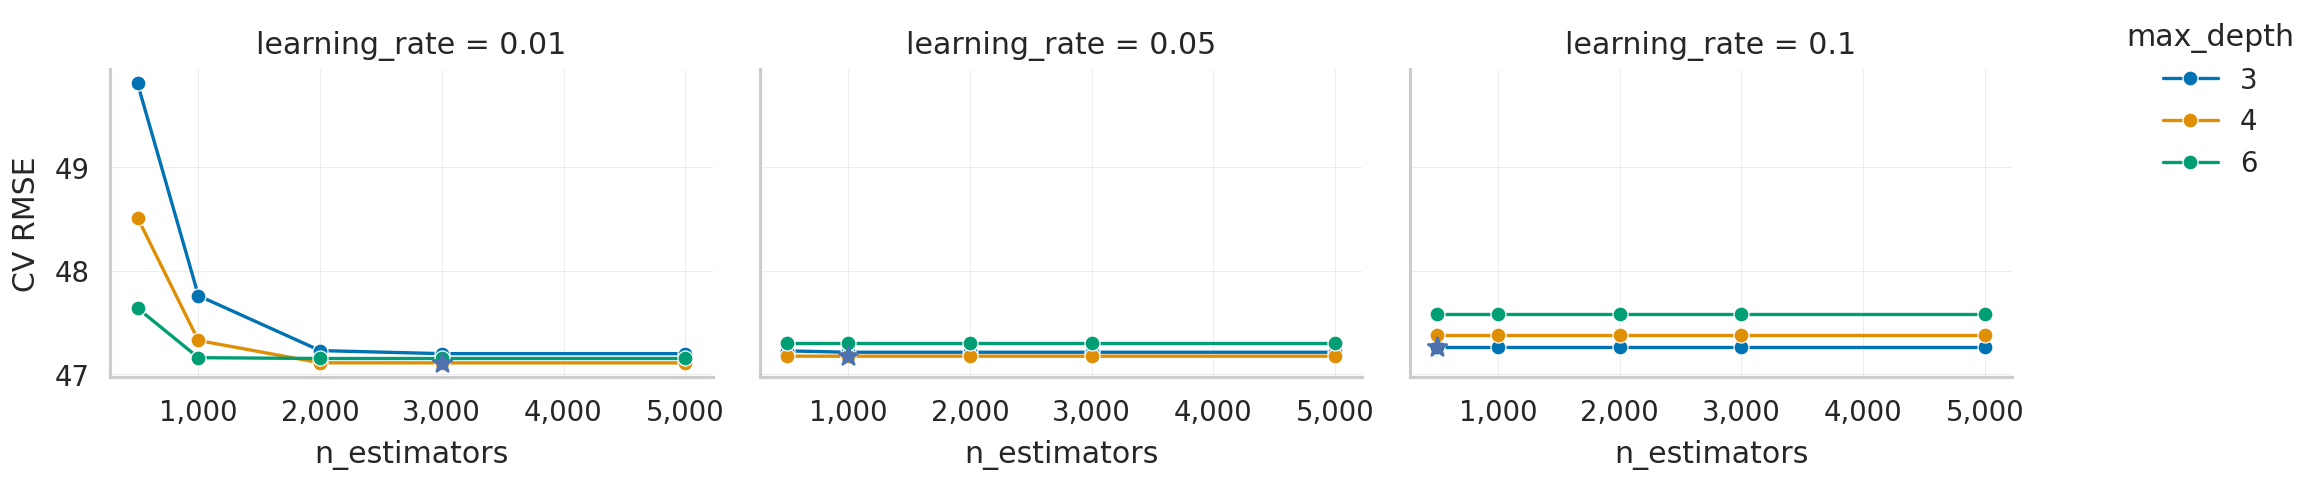

Saved → /content/drive/MyDrive/MSc Research/HPT_10_grid/cv_rmse_vs_trees_10.png and /content/drive/MyDrive/MSc Research/HPT_10_grid/cv_rmse_vs_trees_10.svg


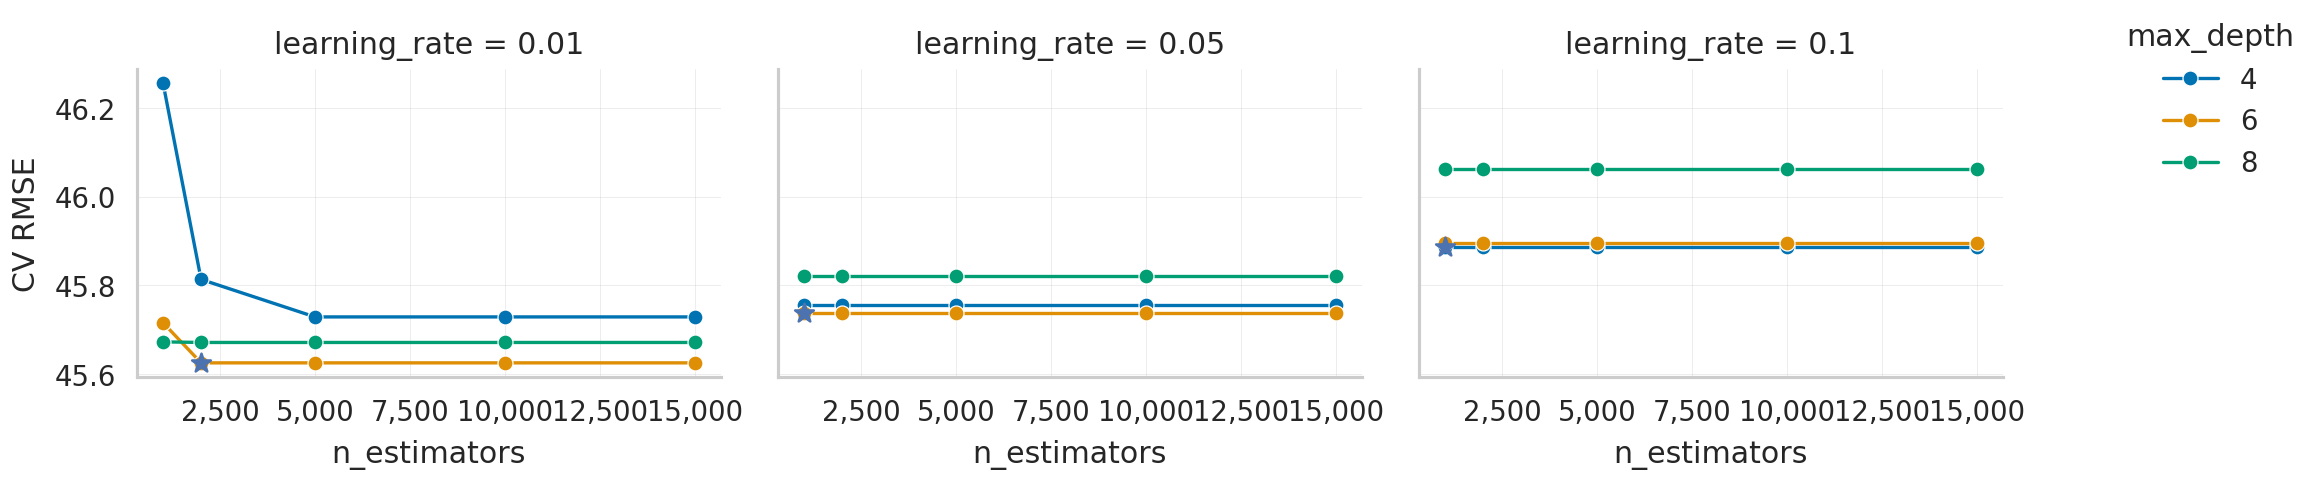

Saved → /content/drive/MyDrive/MSc Research/HPT_25_grid/cv_rmse_vs_trees_25.png and /content/drive/MyDrive/MSc Research/HPT_25_grid/cv_rmse_vs_trees_25.svg


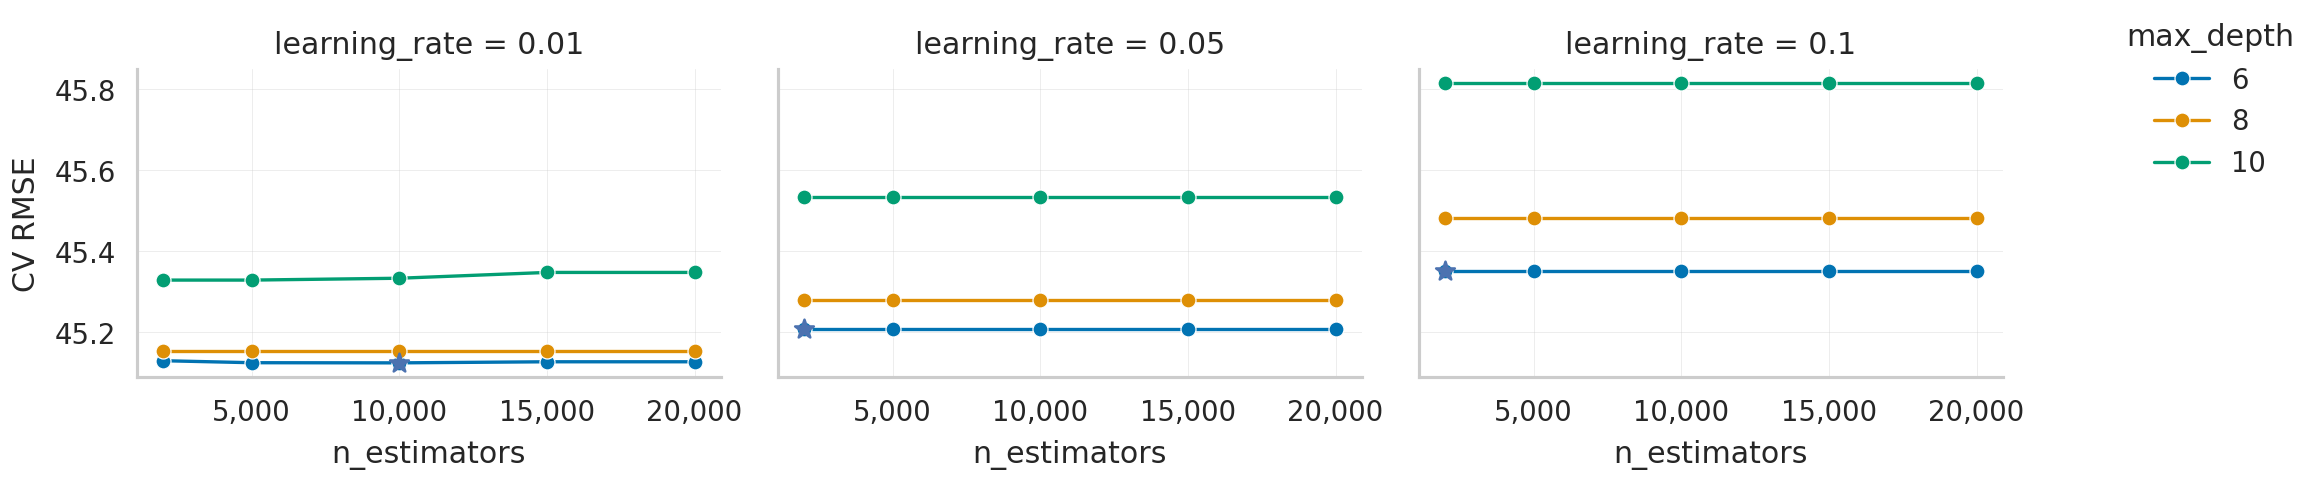

Saved → /content/drive/MyDrive/MSc Research/HPT_50_grid/cv_rmse_vs_trees_50.png and /content/drive/MyDrive/MSc Research/HPT_50_grid/cv_rmse_vs_trees_50.svg


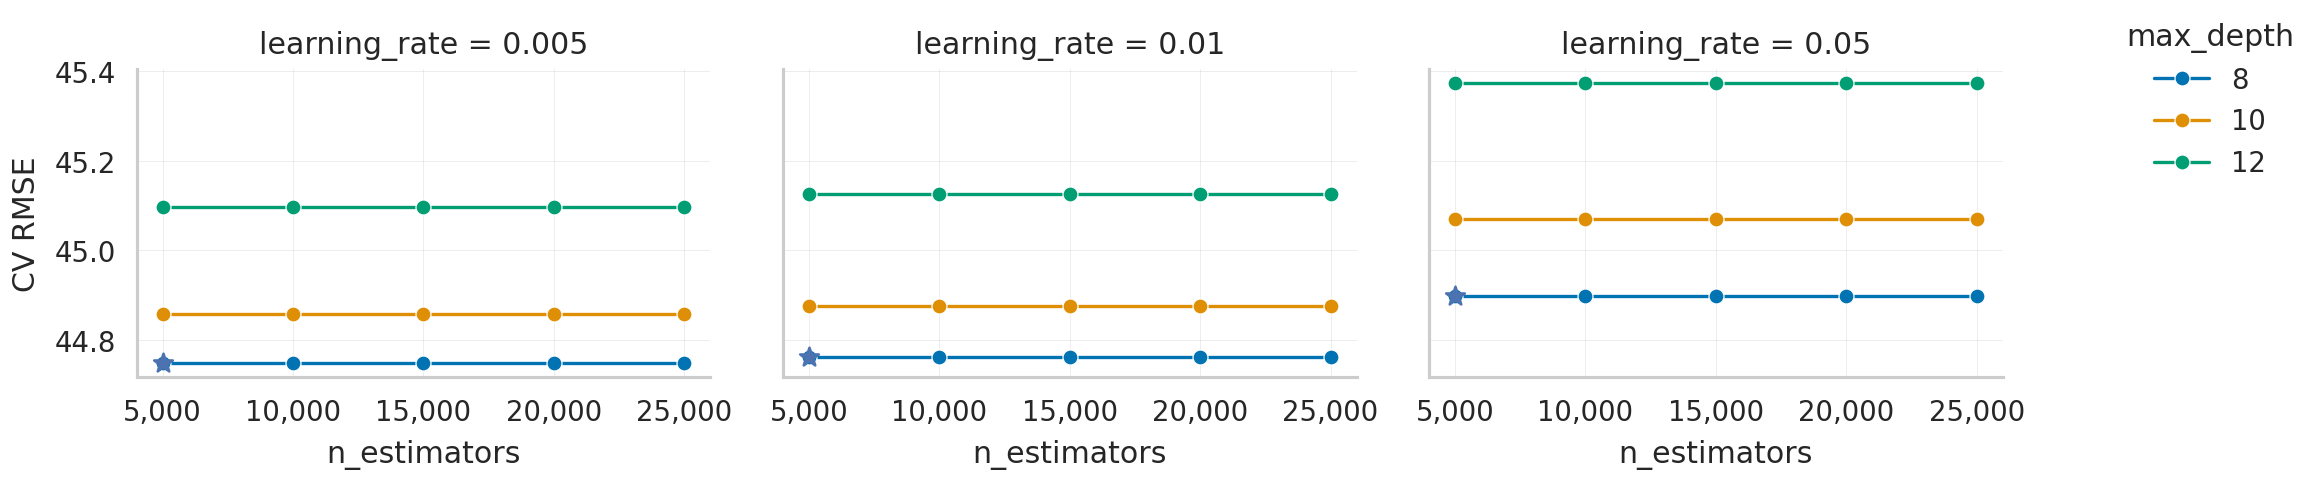

Saved → /content/drive/MyDrive/MSc Research/HPT_75/cv_rmse_vs_trees_75.png and /content/drive/MyDrive/MSc Research/HPT_75/cv_rmse_vs_trees_75.svg


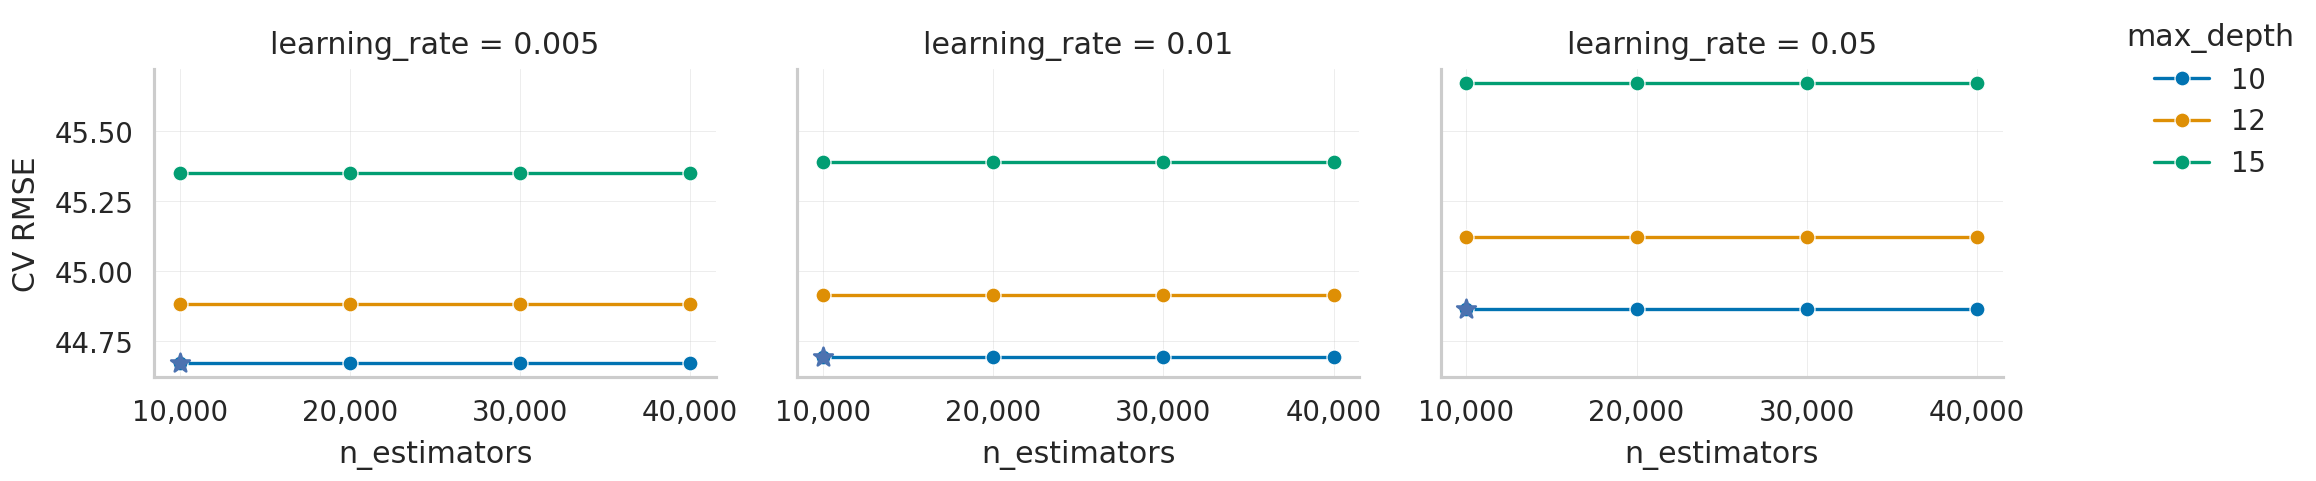

Saved → /content/drive/MyDrive/MSc Research/HPT_full_grid/cv_rmse_vs_trees_full.png and /content/drive/MyDrive/MSc Research/HPT_full_grid/cv_rmse_vs_trees_full.svg


In [ ]:
# Pretty CV-RMSE vs #Trees plots (facet by learning_rate, line by max_depth)
import os, json, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

def plot_cv_rmse_vs_trees(base_dir, csv_name, out_stem):
    sns.set_theme(style="whitegrid", context="talk")
    plt.rcParams.update({
        "axes.titlepad": 10, "axes.labelpad": 8,
        "legend.frameon": False, "figure.dpi": 120
    })

    # --- load & unpack ---
    df  = pd.read_csv(os.path.join(base_dir, csv_name))
    par = pd.json_normalize(df["params"].apply(json.loads))
    d   = pd.concat([df[["cv_rmse"]], par], axis=1)
    d.rename(columns={"n_estimators": "trees"}, inplace=True)

    # tidy
    for c in ["trees", "max_depth", "learning_rate"]:
        d[c] = pd.to_numeric(d[c])

    # aggregate (defensive)
    d = (d.groupby(["learning_rate", "max_depth", "trees"], as_index=False)
           ["cv_rmse"].mean()
           .sort_values("trees"))

    # consistent order
    col_order = sorted(d["learning_rate"].unique())
    hue_order = sorted(d["max_depth"].unique())

    # figure
    g = sns.FacetGrid(
        d, col="learning_rate", col_order=col_order,
        sharey=True, height=4.2, aspect=1.25, despine=True
    )
    g.map_dataframe(
        sns.lineplot, x="trees", y="cv_rmse",
        hue="max_depth", hue_order=hue_order, marker="o",
        palette="colorblind", linewidth=2, err_style=None
    )
    g.add_legend(title="max_depth", bbox_to_anchor=(1.02, 1), loc="upper left")

    # axis labels (no title)
    g.set_axis_labels("n_estimators", "CV RMSE")
    g.set_titles("learning_rate = {col_name}")

    # thousand separators for #trees
    for ax in g.axes.flat:
        ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}"))
        ax.grid(True, which="major", linewidth=0.6, alpha=0.35)

    # highlight best per learning rate (★)
    best_rows = d.loc[d.groupby("learning_rate")["cv_rmse"].idxmin()]
    for ax, lr in zip(g.axes.flat, col_order):
        r = best_rows[best_rows["learning_rate"] == lr].iloc[0]
        ax.scatter(r["trees"], r["cv_rmse"], s=140, marker="*", zorder=5)

    plt.tight_layout()

    # save PNG + SVG
    png = os.path.join(base_dir, f"{out_stem}.png")
    svg = os.path.join(base_dir, f"{out_stem}.svg")
    plt.savefig(png, dpi=300, bbox_inches="tight")
    plt.savefig(svg, bbox_inches="tight")
    plt.show()
    print("Saved →", png, "and", svg)

# run for each subset (no title argument)
plot_cv_rmse_vs_trees("/content/drive/MyDrive/MSc Research/HPT_10_grid",
                      "xgb_grid_10_results.csv", "cv_rmse_vs_trees_10")
plot_cv_rmse_vs_trees("/content/drive/MyDrive/MSc Research/HPT_25_grid",
                      "xgb_grid_25_results.csv", "cv_rmse_vs_trees_25")
plot_cv_rmse_vs_trees("/content/drive/MyDrive/MSc Research/HPT_50_grid",
                      "xgb_grid_50_results.csv", "cv_rmse_vs_trees_50")
plot_cv_rmse_vs_trees("/content/drive/MyDrive/MSc Research/HPT_75",
                      "xgb_grid_75_results.csv", "cv_rmse_vs_trees_75")
plot_cv_rmse_vs_trees("/content/drive/MyDrive/MSc Research/HPT_full_grid",
                      "xgb_grid_full_results.csv", "cv_rmse_vs_trees_full")
